In [186]:
# Ref.)
# https://github.com/Shedka/citiesatnight/blob/5f17f1b323740cea77623ad038a8e713c25849db/frqi.py
# https://arxiv.org/pdf/1812.11042.pdf
# https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import datasets, transforms

%matplotlib inline

def genGraycode(nbit):
    graycode = ['0', '1']

    for _ in range(nbit-1):
        mirrored = reversed(graycode)
        graycode = ['0'+g for g in graycode]
        graycode = graycode + ['1'+m for m in mirrored]
    
    return graycode

def MCRY(theta, n_controlbit):
    t = 2**(n_controlbit + 1)
    mat = np.identity(t)
    # higher qubit indices are more significant (little endian convention)
    #      ┌───┐
    # q_0: ┤ X ├
    #      └─┬─┘
    # q_1: ──■──
    #        │
    # q_2: ──■──
#     mat[t-2, t-2] = np.cos(np.pi/4)
#     mat[t-2, t-1] = -np.sin(np.pi/4)
#     mat[t-1, t-2] = np.sin(np.pi/4)
#     mat[t-1, t-1] = np.cos(np.pi/4)

    # q_0: ──■──
    #        │
    # q_1: ──■──
    #      ┌─┴─┐
    # q_2: ┤ X ├
    #      └───┘
    mat[t//2-1, t//2-1] = np.cos(theta/2)
    mat[t//2-1, t-1] = -np.sin(theta/2)
    mat[t-1, t//2-1] = np.sin(theta/2)
    mat[t-1, t-1] = np.cos(theta/2)

    return UnitaryGate(mat, label=f'theta={theta}')

0


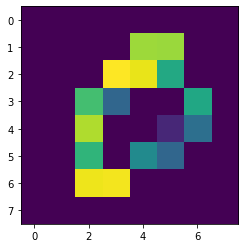

In [187]:
# img_folder = "C:/Users/thesi/Downloads/MNIST Dataset JPG format/MNIST Dataset JPG format/MNIST - JPG - training/0/"
# img_path = img_folder + "1.jpg"
# img_folder = "C:/Users/thesi/Downloads/MNIST Dataset JPG format/MNIST Dataset JPG format/MNIST - JPG - training/1/"
# img_path = img_folder + "3.jpg"

# img = cv2.imread(img_path, 0)

train_data = datasets.MNIST(root='./data', train=True, download=True)

img, label = train_data[1]
img = np.array(img)

""" image reszie from 28x28 to 32x32 """
img_size = 8
img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)

""" Image Visualization """
print(label)
plt.imshow(img)
plt.show()

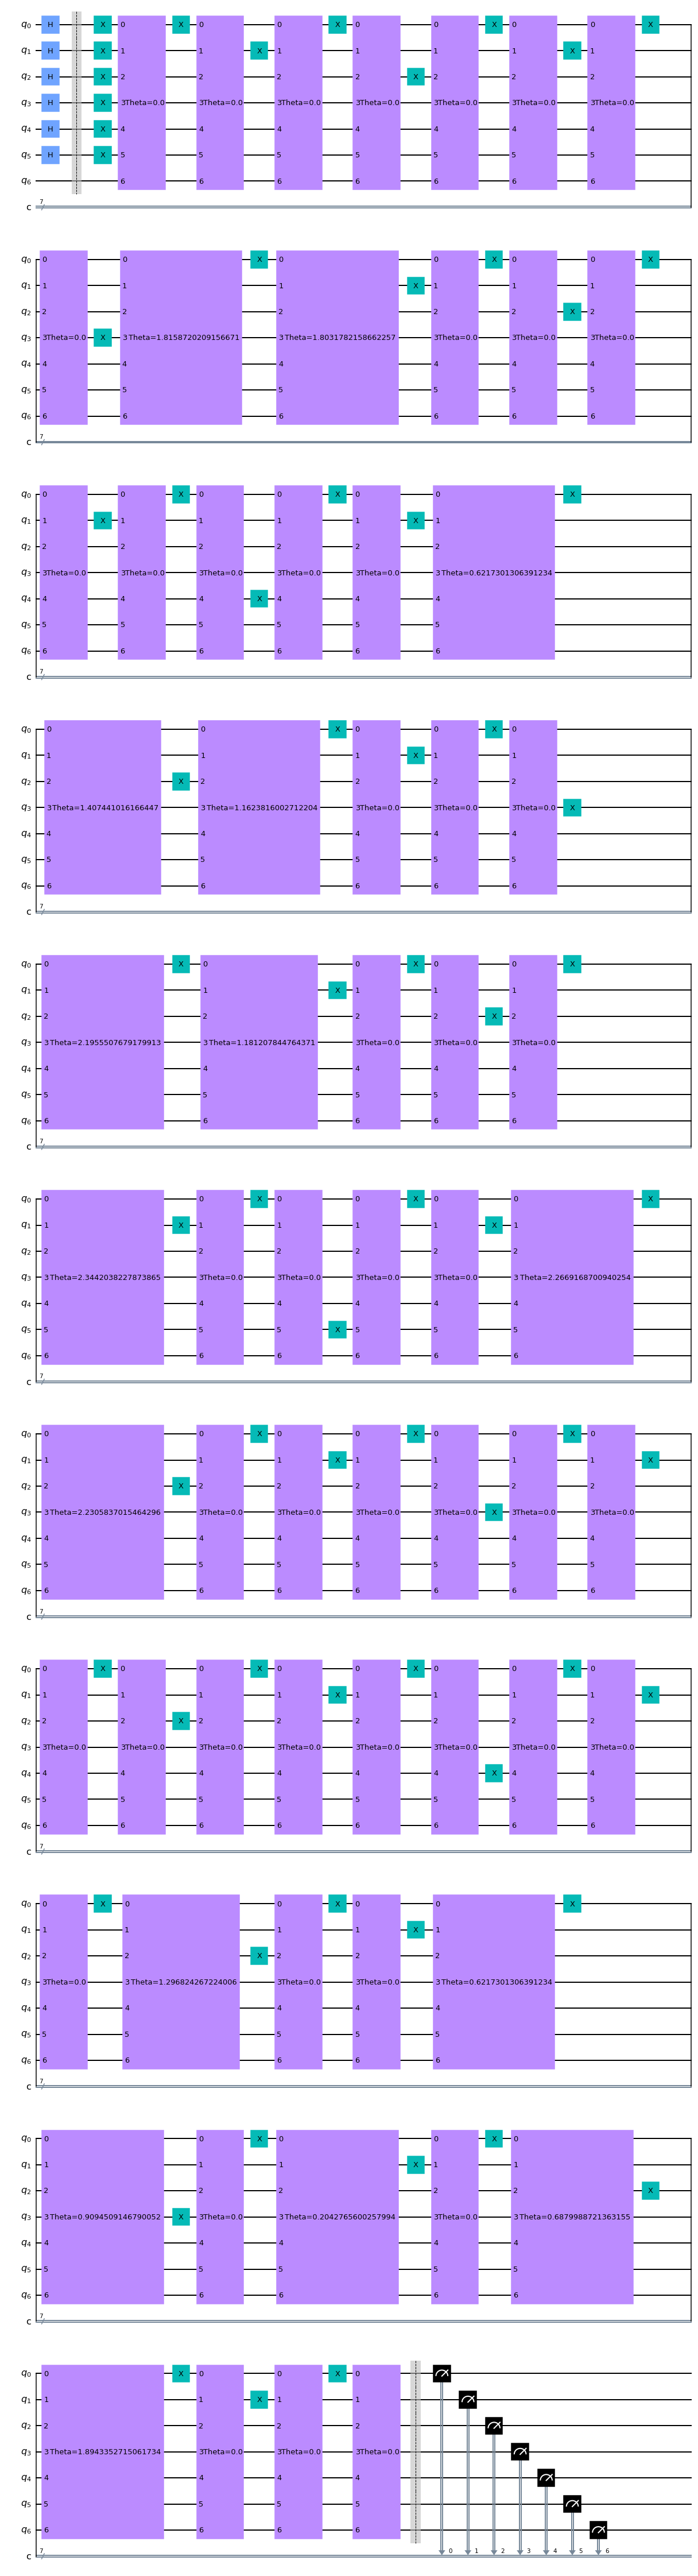

In [188]:
""" 2d to 1d """
img = img.reshape(img_size*img_size)

""" Nomralization (0~1 == sin(0)~sin(pi/2)) """
img = img / 255.0

""" calculate theta """
img = np.arcsin(img)

# provider = IBMQ.load_account()


""" Create Multi-controlled RY Gate """
k = int(np.ceil(np.log2(img_size)))

""" Design circuit """
qc = QuantumCircuit(2*k+1, 2*k+1)

qc.h(range(0, 2*k))

graycode = genGraycode(2*k)

qc.barrier()
# for i, e in enumerate(img):
#     if i == 0:
#         qc.x(range(0, 2*k))
#     else:
#         for j in range(2*k):
#             if graycode[i-1][j] != graycode[i][j]:
#                 qc.x(j)
#                 break
#     mcry = MCRY(2 * img[i], 2*k)
#     qc.append(mcry, range(0, 2*k+1))
    
for i in range(len(img)):
    if i == 0:
        qc.x(range(2*k))
    else:
        for j in range(2*k):
            if graycode[i-1][2*k-j-1] != graycode[i][2*k-j-1]:
                qc.x(j)
                break
    idx = int(graycode[i], 2)
    mcry = MCRY(2 * img[idx], 2*k)
    qc.append(mcry, range(2*k+1))

qc.barrier()
    
qc.measure(range(2*k+1), range(2*k+1))

# qc = qc.reverse_bits()

qc.draw(output='mpl')

<ipython-input-189-5e75733cbaf2>:7: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = execute(qc, backend=backend, shots=shots, backend_options={"fusion_enable":True})


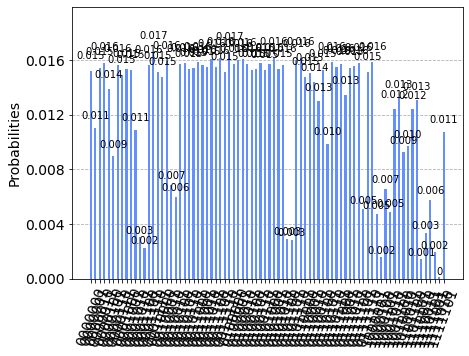

In [189]:
""" run simulator """
shots = 100000
# provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
# job = execute(qc, backend=backend, shots=shots, seed_simulator=12345, backend_options={"fusion_enable":True})
job = execute(qc, backend=backend, shots=shots, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=shots)
result = job.result()
count = result.get_counts()
plot_histogram(count)

1000000 None
1000001 476
1000010 None
1000011 None
1000100 158
1000101 655
1000110 None
1000111 None
1001000 None
1001001 None
1001010 486
1001011 1245
1001100 1319
1001101 None
1001110 None
1001111 None
1010000 None
1010001 None
1010010 928
1010011 970
1010100 None
1010101 None
1010110 None
1010111 None
1011000 None
1011001 None
1011010 None
1011011 None
1011100 None
1011101 None
1011110 None
1011111 None
1100000 None
1100001 None
1100010 None
1100011 None
1100100 None
1100101 None
1100110 None
1100111 None
1101000 None
1101001 None
1101010 None
1101011 None
1101100 1243
1101101 1305
1101110 None
1101111 None
1110000 None
1110001 None
1110010 148
1110011 335
1110100 None
1110101 579
1110110 None
1110111 None
1111000 None
1111001 197
1111010 14
1111011 None
1111100 None
1111101 1076
1111110 None
1111111 None
[  267.  -146.   295.   329.   137.  -351.   316.   241.   286.   276.
  -162.  -947. -1022.   314.   407.   266.   225.   340.  -566.  -650.
   318.   325.   285.   289.   335.   

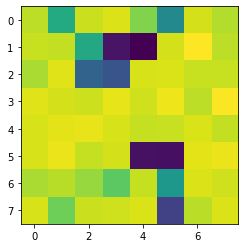

In [191]:
""" decode """
genimg = []
# for i in range(0, img_size*img_size):
#     print('{0:02b}'.format(i))
for i in range(0, img_size*img_size):
    b = '{0:06b}'.format(i)
    b0 = count.get('0'+b)
#     print('0'+b, b0)
    if b0 == None:
        b0 = 0.
    b1 = count.get('1'+b)
    print('1'+b, b1)
    if b1 == None:
        b1 = 0.
    try:
#         genimg = np.append(genimg, b1*100/(b0+b1))
        genimg = np.append(genimg, b0-shots/len(count))
    except:
        genimg = np.append(genimg, 0.)
#     try:
#         genimg = np.append(genimg, count.pop('1'+'{0:06b}'.format(i)))
#     except:
#         try:
#             genimg = np.append(genimg, count.pop('0'+'{0:06b}'.format(i)))
#         except:
#             genimg = np.append(genimg, [0.])
print(genimg)
genimg = genimg * 100. *255.
genimg = genimg.astype('int')
genimg = genimg.reshape((img_size, img_size))
plt.imshow(genimg)
plt.show()

In [192]:
print(count)
print(type(count))

{'0000000': 1517, '0000001': 1104, '0010000': 1475, '0010001': 1590, '0010010': 684, '0010011': 600, '0010100': 1568, '0010101': 1575, '0010110': 1535, '0010111': 1539, '0011000': 1585, '0011001': 1564, '0011010': 1549, '0011011': 1605, '0011100': 1551, '0011101': 1618, '0011110': 1512, '0011111': 1651, '0000010': 1545, '0100000': 1569, '0100001': 1600, '0100010': 1608, '0100011': 1569, '0100100': 1530, '0100101': 1536, '0100110': 1576, '0100111': 1526, '0101000': 1573, '0101001': 1616, '0101010': 1534, '0101011': 1566, '0101100': 294, '0101101': 284, '0101110': 1600, '0101111': 1617, '0000011': 1579, '0110000': 1478, '0110001': 1504, '0110010': 1437, '0110011': 1297, '0110100': 1530, '0110101': 989, '0110110': 1583, '0110111': 1551, '0111000': 1568, '0111001': 1344, '0111010': 1544, '0111011': 1555, '0111100': 1577, '0111101': 511, '0111110': 1509, '0111111': 1584, '0000100': 1387, '1000001': 476, '1000100': 158, '1000101': 655, '1001010': 486, '1001011': 1245, '1001100': 1319, '00001

In [193]:
shots/len(count)

1250.0

In [194]:
count.values()

dict_values([1517, 1104, 1475, 1590, 684, 600, 1568, 1575, 1535, 1539, 1585, 1564, 1549, 1605, 1551, 1618, 1512, 1651, 1545, 1569, 1600, 1608, 1569, 1530, 1536, 1576, 1526, 1573, 1616, 1534, 1566, 294, 284, 1600, 1617, 1579, 1478, 1504, 1437, 1297, 1530, 989, 1583, 1551, 1568, 1344, 1544, 1555, 1577, 511, 1509, 1584, 1387, 476, 158, 655, 486, 1245, 1319, 899, 928, 970, 1566, 1243, 1305, 1491, 148, 335, 579, 197, 14, 1076, 1536, 1526, 1088, 303, 228, 1564, 1657, 1516])

In [195]:
print(count.keys())

dict_keys(['0000000', '0000001', '0010000', '0010001', '0010010', '0010011', '0010100', '0010101', '0010110', '0010111', '0011000', '0011001', '0011010', '0011011', '0011100', '0011101', '0011110', '0011111', '0000010', '0100000', '0100001', '0100010', '0100011', '0100100', '0100101', '0100110', '0100111', '0101000', '0101001', '0101010', '0101011', '0101100', '0101101', '0101110', '0101111', '0000011', '0110000', '0110001', '0110010', '0110011', '0110100', '0110101', '0110110', '0110111', '0111000', '0111001', '0111010', '0111011', '0111100', '0111101', '0111110', '0111111', '0000100', '1000001', '1000100', '1000101', '1001010', '1001011', '1001100', '0000101', '1010010', '1010011', '0000110', '1101100', '1101101', '0000111', '1110010', '1110011', '1110101', '1111001', '1111010', '1111101', '0001000', '0001001', '0001010', '0001011', '0001100', '0001101', '0001110', '0001111'])
